## Class Test to understand __get_item__



In [1]:


import numpy as np

class MyMedicalDataset:
    def __init__(self, image_paths, labels, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        
        return len(self.image_paths)

    def __getitem__(self, idx):
       
        # When you do dataset[i], this method is called with idx = i

        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # In a real scenario, you'd load the image (e.g., DICOM with pydicom/MONAI LoadImage)
        # For simplicity, let's pretend we load a dummy image
        image_data = np.random.rand(64, 64) # Simulate loading an image

        # Apply transforms if provided (e.g., MONAI transforms)
        if self.transforms:
            # MONAI transforms expect dictionaries
            data_dict = {"image": image_data, "label": label}
            data_dict = self.transforms(data_dict)
            image_data = data_dict["image"]
            label = data_dict["label"]

        return {"image": image_data, "label": label}

# --- Usage Example ---
image_files = ["img1.dcm", "img2.dcm", "img3.dcm"]
labels_data = [0, 1, 0]

# Imagine some MONAI transforms here
from monai.transforms import RandFlip, Compose, AsDiscrete, EnsureChannelFirstd

 #my_transforms = Compose([
#     EnsureChannelFirstd(keys="image"),
#     RandFlip(prob=0.5, spatial_axis=None)
    
# ])


dataset = MyMedicalDataset(image_files, labels_data, transforms=None)

# This calls dataset.__getitem__(0)
first_item = dataset[0]
print(f"Type of first_item: {type(first_item)}")
print(f"Keys in first_item: {first_item.keys()}")
print(f"Shape of first_item['image']: {first_item['image'].shape}")

# This calls dataset.__len__()
print(f"Dataset length: {len(dataset)}")

# This indirectly uses __getitem__ (and __len__) for iteration
for i in range(len(dataset)):
    item = dataset[i]
    print(f"Processing item {i}")

# Test on the class itself 
print(f"images path : {dataset.image_paths}" )
print(f"labels : {dataset.labels}")
print(f"Transforms : {dataset.transforms}")

/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Type of first_item: <class 'dict'>
Keys in first_item: dict_keys(['image', 'label'])
Shape of first_item['image']: (64, 64)
Dataset length: 3
Processing item 0
Processing item 1
Processing item 2
images path : ['img1.dcm', 'img2.dcm', 'img3.dcm']
labels : [0, 1, 0]
Transforms : None


## RSNA class


In [69]:
from torch.utils.data import Dataset
import pydicom
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import monai.transforms as T

def safe_get_first(value, default):
    try:
        if isinstance(value, pydicom.multival.MultiValue):
            return float(value[0])
        else:
            return float(value)
    except Exception:
        return float(default)
    

class RSNA_DICOM_Dataset(Dataset):
    def __init__(self, csv_path, dicom_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.dicom_dir = Path(dicom_dir)
        self.transform = transform
        self.label_cols = [ 'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        self.loader = T.LoadImage(image_only=False)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dcm_path = self.dicom_dir / row['filename']
        dcm = pydicom.dcmread(str(dcm_path))

        # Load image
        image, meta = self.loader(str(dcm_path)) # Using MONAI's LoadImage

        dicom_raw = pydicom.dcmread(str(dcm_path))

        center = safe_get_first(getattr(dcm, 'WindowCenter', 40), 40)
        width = safe_get_first(getattr(dcm, 'WindowWidth', 80), 80)
        slope = safe_get_first(getattr(dcm, 'RescaleSlope', 1), 1)
        intercept = safe_get_first(getattr(dcm, 'RescaleIntercept', 0), 0)
        

        img_np = image.astype(np.float32)
        img_np = img_np * slope + intercept

        img_windowed = np.clip(img_np, center - width // 2, center + width // 2)
        img_norm = (img_windowed - img_windowed.min()) / (img_windowed.max() - img_windowed.min() + 1e-5)

        # ==== 4. Conversion en tenseur PyTorch + ajout canal (C, H, W)
        img_tensor = torch.from_numpy(img_norm).float().unsqueeze(0)  # [1, H, W]

        # ==== 5. Resize etc.
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # ==== 6. Extraction des labels
        label = torch.tensor(row[self.label_cols].values.astype(np.float32))
        # print("DICOM path:", dcm_path)
        # print("Row filename:", row['filename'])
        # print("Row labels:", row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])  
        return img_tensor, label


In [73]:
#Vérifif alignement entre csv et get_item

csv_path = csv_path = Path("/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/csv/train_fold0.csv")
df = pd.read_csv(csv_path)

print(df.iloc[1001])


filename            ID_357ebf7aa.dcm
any                                1
epidural                           0
intraparenchymal                   0
intraventricular                   1
subarachnoid                       0
subdural                           1
PatientID                ID_00760731
Name: 1001, dtype: object


Number of samples in the dataset: 539469
torch.Size([1, 224, 224])
tensor([1., 0., 0., 1., 0., 1.])


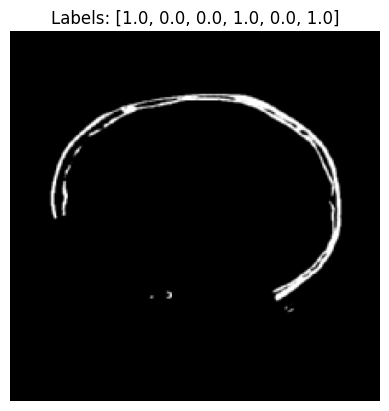

In [77]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

resize_transform = T.Resize((224, 224))
csv_path = Path("/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/csv/train_fold0.csv")
dicom_dir = Path("/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/rsna-intracranial-hemorrhage-detection/stage_2_train")
train_dataset = RSNA_DICOM_Dataset(csv_path, dicom_dir, transform=resize_transform)
print(f"Number of samples in the dataset: {len(train_dataset)}")

image, label = train_dataset[1001]
print(image.shape)  # [1, 224, 224]
print(label)  
image_np = image.squeeze(0).numpy()

# Affichage
plt.imshow(image_np, cmap='gray')
plt.title(f"Labels: {label.tolist()}")
plt.axis('off')
plt.show()  

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [44]:
# Inspecting attr after 36th samples  in the dataset:

import pydicom
from pathlib import Path

def safe_get_float(value, default):
    if isinstance(value, pydicom.multival.MultiValue):
        return float(value[0])
    try:
        return float(value)
    except Exception:
        return float(default)

# --- Paths ---
csv_path = "/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/csv/train_fold0.csv"
dicom_dir = "/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/rsna-intracranial-hemorrhage-detection/stage_2_train"

import pandas as pd
df = pd.read_csv(csv_path)

# Sample index
i = 47
dcm_path = Path(dicom_dir) / df.iloc[i]["filename"]
dcm = pydicom.dcmread(str(dcm_path))
dicom_raw = pydicom.dcmread(str(dcm_path))
# Safe attribute reads
center = (dicom_raw.WindowCenter)
print("center", center)
width = (dicom_raw.WindowWidth)
print("width", width)
slope = (dicom_raw.RescaleSlope)
print("slope", slope)
intercept = float(dicom_raw.RescaleIntercept)
print("intercept", intercept)


# Safe attribute reads
center_2 = safe_get_float(getattr(dcm, 'WindowCenter', 40), 40)
width_2 = safe_get_float(getattr(dcm, 'WindowWidth', 80), 80)
slope_2 = safe_get_float(getattr(dcm, 'RescaleSlope', 1), 1)
intercept_2 = safe_get_float(getattr(dcm, 'RescaleIntercept', 0), 0)

print("center_2", center_2)
print("width_2", width_2)
print("slope_2", slope_2)
print("intercept_2", intercept_2)


center [00036, 00036]
width [00080, 00080]
slope 1
intercept -1024.0
center_2 36.0
width_2 80.0
slope_2 1.0
intercept_2 -1024.0


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from monai.networks.nets import densenet121
from monai.transforms import Compose, Resize, ToTensor
from tqdm import tqdm

# === Hyperparams ===
NUM_CLASSES = 6
BATCH_SIZE = 32
EPOCHS = 3
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,persistent_workers= True,pin_memory=True)
print(f"Using device: {DEVICE}")
print(f"Number of Batches in the dataset: {len(train_loader)}")

# === Model ===
model = densenet121(spatial_dims=2, in_channels=1, out_channels=NUM_CLASSES)
model.to(DEVICE)
model.state_dict()
# === Loss (inspirée de ton doctorant)

pos_weights = torch.tensor([1.0] * NUM_CLASSES, dtype=torch.float).to(DEVICE)
print(f"répartition des poids : {pos_weights}")
loss_fn= nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# === Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Using device: cuda
Number of Batches in the dataset: 16859
répartition des poids : tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


In [82]:
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
    total_time=end-start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def compute_accuracy(y_pred, y_true, threshold=0.5):
    """
    Renvoie l'accuracy multilabel (exact match pour chaque label indépendamment).
    """
    preds = torch.sigmoid(y_pred) > threshold
    correct = (preds == y_true.bool()).float()
    return correct.mean().item()

In [ ]:
# === Training Loop ===
from tqdm import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0

    for batch, (X,y) in enumerate(train_loader):
        X,y=X.to(DEVICE),y.to(DEVICE)
        
        # Forward
        y_pred = model(X)
        #Calculate loss per batch 
        loss = loss_fn(y_pred, y)
        epoch_loss += loss
        acc = compute_accuracy(y_pred, y)
        if batch % 1000 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples")

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    avg_loss = epoch_loss / len(train_loader)
    avg_acc = epoch_acc / len(train_loader)
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={avg_acc:.4f}")

end_time = timer()
total_train_time = print_train_time(start_time, end_time, DEVICE)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/539469 samples
Looked at 32000/539469 samples


  0%|          | 0/3 [06:54<?, ?it/s]


KeyboardInterrupt: 

: 

In [ ]:
  ## Testing
# --- Paths ---
csv_path = "/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/csv/val_fold0.csv"
dicom_dir = "/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/rsna-intracranial-hemorrhage-detection/stage_2_train"



test_loss,test_acc=0,0
model.eval()
with torch.inference_mode():
    for X_test,y_test in test_dataloader:
        # Forward
      test_pred=model_0(X_test)
          # Calculate loss
      test_loss += loss_fn(test_pred,y_test)
          # Accuracy
      test_acc += accuracy_fn(y_true=y_test,y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.4f}")